In [76]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import random

%matplotlib inline

#To display all outputs in a cell rather than the last output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
DF = pd.merge(study_results, mouse_metadata, how='left', on='Mouse ID')

In [14]:
# Checking the number of mice in the DataFrame.
DF['Mouse ID'].value_counts().count()

249

In [15]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
# Note:- As per the description, for a timepoint, there should be only one entry for any mouse


#Duplicate Mice
duplicate_mice_ids = list(DF[DF.duplicated(subset=['Mouse ID','Timepoint'], keep = False)]['Mouse ID'].unique())
duplicate_mice_ids

['g989']

In [16]:
# Optional: Get all the data for the duplicate mouse ID. 

#Extra:- Duplicated Entries are displayed as follows:
#DF[DF.duplicated(subset=['Mouse ID','Timepoint'], keep = False)]

DF[DF['Mouse ID'].isin(duplicate_mice_ids)]
#13 rows for this mouse

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [17]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
# Note:- All data corresponding to this mouse is dropped

DF.drop(DF[DF['Mouse ID'].isin(duplicate_mice_ids)].index, axis=0, inplace=True)
#Left with 1880 rows

In [18]:
# Checking the number of mice in the clean DataFrame.
DF['Mouse ID'].value_counts().count()

248

## Summary Statistics

In [19]:
######################################PLEASE READ THIS######################################
#1. Though we are taking a complete data set, it has to be considered as sample NOT population. Reason being, 248 mice represents entire population of mice here to derive the study results
#2. Because of 1, variance formula should be that of sample variance (ddof = 1, losing 1 degree  of freedom as sample mean is derived from the same data)
#3. Because of 1, std deviation formula should be that of sample std deviation (ddof = 1, losing 1 degree  of freedom as sample mean is derived from the same data)
#4. Most importantly, because of 1, SEM is not a relevant statistics here. SEM is the std. error of mean. It is tied to CLT (Central Limit Theorem), which says, the sample mean of "truly" randomly \
####picked ensembles converge to the population mean with std error of mean (SEM) = population std /sqrt(of ensemble size). This is used to derive population std deviation from samples.
####Means, if we know SEM, then std.deviation = SEM*ensemble size. 
####The scipy implementation of SEM is std_dev/sqrt(size of array) is not useful for us. I am using SEM(ddof =1) here, just to match up with std calculation. But, rightfully, we shouldn't take SEM here.

In [20]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method is the most straightforward, creating multiple series and putting them all together at the end.

#Create a group based on 'Drug Regimen'
drug_regimen_grp = DF.groupby('Drug Regimen')
mean = drug_regimen_grp['Tumor Volume (mm3)'].mean()
median = drug_regimen_grp['Tumor Volume (mm3)'].median()
variance = drug_regimen_grp['Tumor Volume (mm3)'].var(ddof=1)
std_dev = drug_regimen_grp['Tumor Volume (mm3)'].std(ddof=1)
sem = drug_regimen_grp['Tumor Volume (mm3)'].apply(lambda x: st.sem(x, ddof=1))

#Combine everything to a DF
summary_stats_method1 = pd.concat([mean, median, variance, std_dev, sem], axis=1)
summary_stats_method1.columns = ['mean', 'median', 'variance', 'std_dev', 'sem']
summary_stats_method1

,mean,median,variance,std_dev,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [21]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method produces everything in a single groupby function.


#Create a group based on 'Drug Regimen'
drug_regimen_grp = DF.groupby('Drug Regimen')
#Aggregate based on the summary stats
summary_stats_method2 = drug_regimen_grp.aggregate(mean=('Tumor Volume (mm3)', 'mean'), median=('Tumor Volume (mm3)', 'median'), variance=('Tumor Volume (mm3)', lambda x:np.var(x, ddof=1)), std_dev = ('Tumor Volume (mm3)', lambda x:np.std(x, ddof=1)), sem = (('Tumor Volume (mm3)', lambda x: st.sem(x, ddof=1))))                  
summary_stats_method2



,mean,median,variance,std_dev,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar Plots

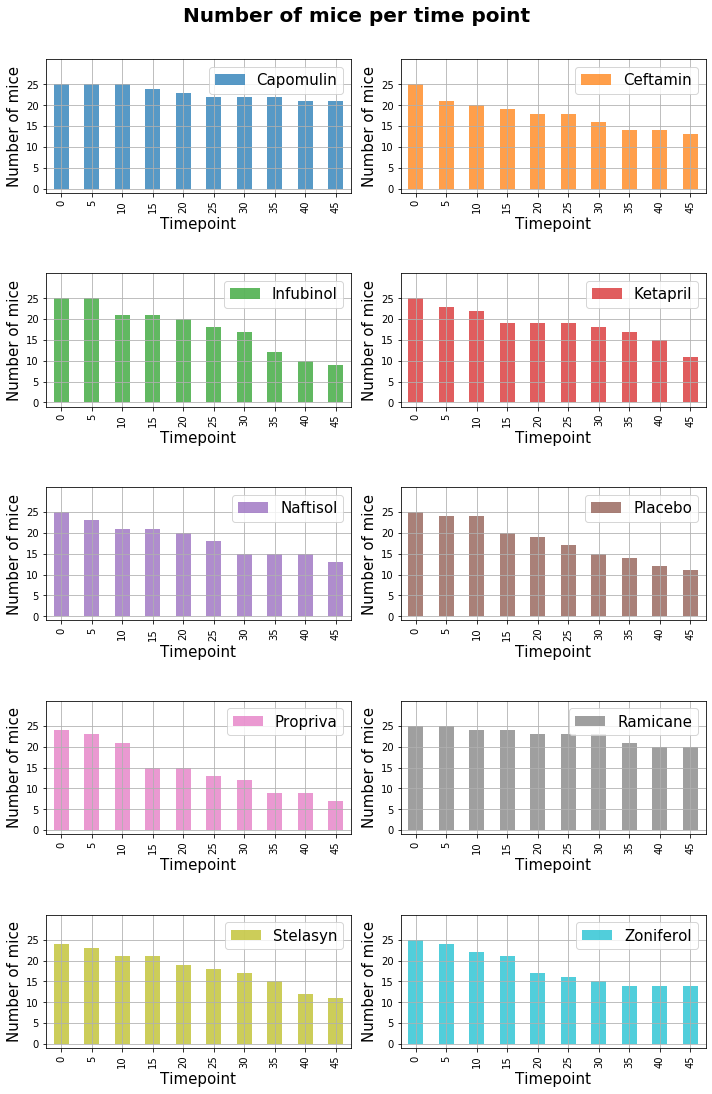

In [22]:
# Generate a bar plot showing the number of mice per time point for each treatment throughout the course of the study using pandas.    

#Group DF with 'Drug Regimen' and 'Timepoint'
#Convert the 'Timepoint' index as columns
Timepoint_Regime_Mice_Number = DF.groupby(['Timepoint', 'Drug Regimen'])['Mouse ID'].count()
TS_Regime_Mice_Number = Timepoint_Regime_Mice_Number.unstack(level=-1, fill_value=0) #By default level=-1

axes = TS_Regime_Mice_Number.plot(
                           width=0.5,
                           kind = 'bar',
                           figsize=(10,15),
                           subplots='True',
                           layout=(len(TS_Regime_Mice_Number.columns)//2, 2), #(5,2)
                           grid=True,
                           legend='False', #To get better control on legends
     
                           sharex=False, sharey=False,
                           
                           yticks=np.arange(0, TS_Regime_Mice_Number.max(axis=1).max(axis=0)+1, 5),
                           xlim=(TS_Regime_Mice_Number.index.to_list()[0]-1, TS_Regime_Mice_Number.index.to_list()[-1]+1),
                           ylim=(-1, TS_Regime_Mice_Number.max(axis=1).max(axis=0)+6),
                           alpha=0.75,
                           
                           )      
#Beautification !!!
_=plt.suptitle('Number of mice per time point', fontsize=20, weight='bold', y=1.01)
axes = axes.reshape(TS_Regime_Mice_Number.columns.shape)
_=[ax.legend(loc='upper right',fontsize = 15) for ax in axes]
_=[ax.set_ylabel('Number of mice',fontsize = 15) for ax in axes]
_=[ax.set_xlabel('Timepoint',fontsize = 15) for ax in axes]
_=[ax.set_title("\n") for ax in axes]
_ = plt.tight_layout()

_= plt.savefig('../Images/graph1.png', bbox_inches = "tight" )
plt.show()

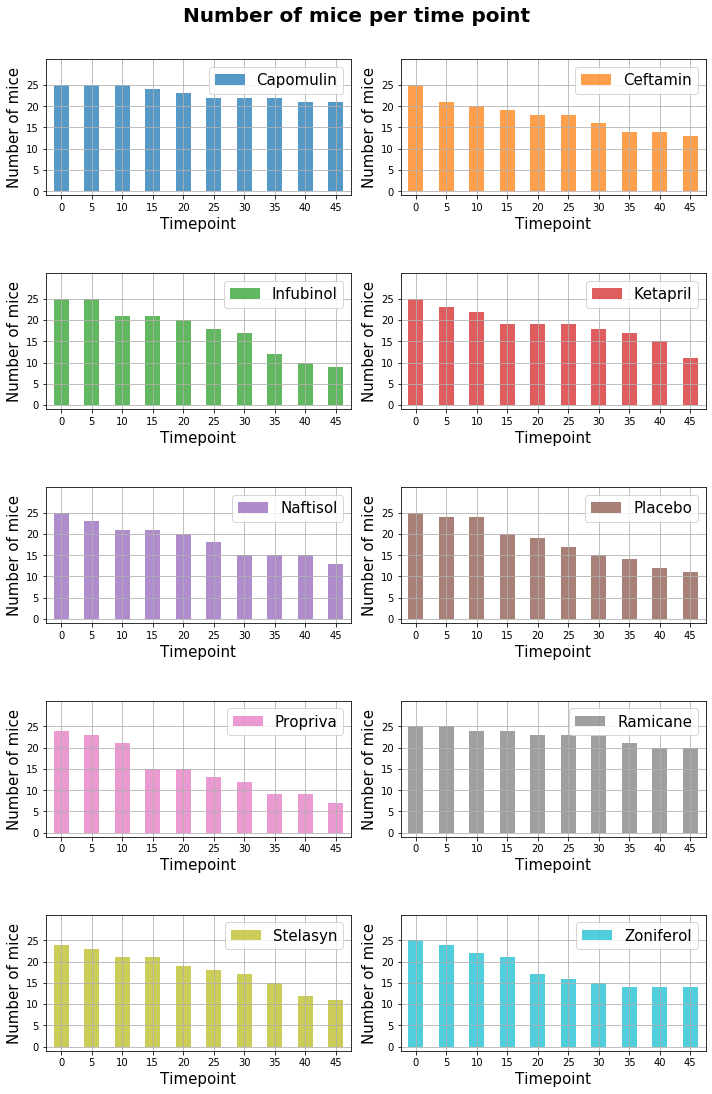

In [23]:
# Generate a bar plot showing the number of mice per time point for each treatment throughout the course of the study using pyplot.

#Group DF with 'Drug Regimen' and 'Timepoint'
#Convert the 'Timepoint' index as columns
Timepoint_Regime_Mice_Number = DF.groupby(['Timepoint', 'Drug Regimen'])['Mouse ID'].count()
TS_Regime_Mice_Number = Timepoint_Regime_Mice_Number.unstack(level=-1, fill_value=0) #By default level=-1
#TS_Regime_Mice_Number

#Generate subplot layout
fig, axes = plt.subplots(len(TS_Regime_Mice_Number.columns)//2, 2, sharex=False, sharey=False, figsize=(10, 15))
#Flatten the axes array
axes = axes.ravel() #Same as axes.reshape(TS_Regime_Mice_Number.columns.shape)
#Take the default color cycler
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#Plot in loop
for index, col in enumerate(TS_Regime_Mice_Number.columns):
    _=axes[index].bar(x = TS_Regime_Mice_Number.index.to_list(), height= TS_Regime_Mice_Number[col].to_list(), color=colors[index], alpha=0.75, label=col, width=2.5)                
    #xticks, yticks
    _=axes[index].set_xticks(TS_Regime_Mice_Number.index.to_list()) 
    _=axes[index].set_xticklabels(TS_Regime_Mice_Number.index.to_list())
    _=axes[index].set_yticks(np.arange(0, TS_Regime_Mice_Number.max(axis=1).max(axis=0)+1, 5))
    _=axes[index].set_yticklabels(np.arange(0, TS_Regime_Mice_Number.max(axis=1).max(axis=0)+1, 5))
    #xlim, ylim
    _=axes[index].set_xlim(TS_Regime_Mice_Number.index.to_list()[0]-2.5, TS_Regime_Mice_Number.index.to_list()[-1]+2.5)
    _=axes[index].set_ylim(-1, TS_Regime_Mice_Number.max(axis=1).max(axis=0)+6)
    #xlabel, ylabel
    _=axes[index].set_xlabel('Timepoint',fontsize = 15)
    _=axes[index].set_ylabel('Number of mice',fontsize = 15)
    #legend
    _=axes[index].legend(loc='upper right', fontsize = 15)
    #title of individual subplots as a blank line
    _=axes[index].set_title("\n")
    #grid on
    _=axes[index].grid()

_=plt.suptitle('Number of mice per time point', fontsize=20, weight='bold', y=1.01)    
_ = plt.tight_layout()
plt.show()



Plot created using Pandas's DataFrame.plot()


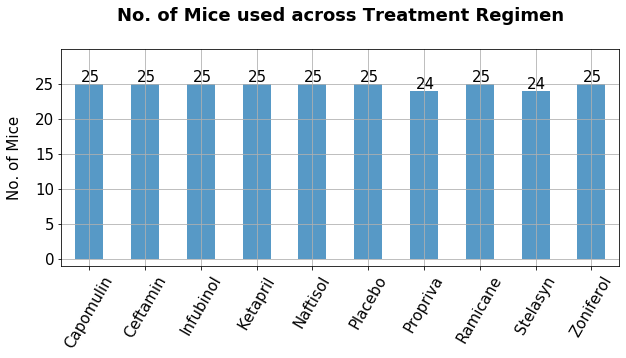

In [46]:
###########################PLEASE READ##################################
# Additional plot as mentioned by Ahmad in slack group(09 Jun: 11:16 PM)
# Generate a bar plot using both Pandas's DataFrame.plot() and Matplotlib's pyplot that shows the number of 
# total mice for each treatment regime throughout the course of the study.

#The below DF contains Mice and the regimen combination
Mice_Regimen_DF = DF.groupby(['Mouse ID', 'Drug Regimen']).aggregate({'Sex':'first'}).reset_index().drop(['Sex'], axis=1)

#Create a column "Number" that corresponds to Mice Count used in each regimen
Regimen_Mice_Count = Mice_Regimen_DF.groupby('Drug Regimen').aggregate(Number = ('Mouse ID', 'count'))
Regimen_Mice_Count.index.name=None

print("Plot created using Pandas's DataFrame.plot()")
#Take the default color cycler
axes = Regimen_Mice_Count.plot(
                           width=0.5,
                           kind = 'bar',
                           figsize=(10,4),
                           grid=True,
                           legend=False,
                           yticks=np.arange(0, int(Regimen_Mice_Count.max())+1, 5),
                           xlim=(-1, len(Regimen_Mice_Count)+1),
                           ylim=(-1, int(Regimen_Mice_Count.max())+5),
                           title="No of Mice used across Treatment Regimen",
                           alpha=0.75,
                           )
_=axes.set_xticklabels(Regimen_Mice_Count.index.to_list(), fontsize=15, rotation=60)
_=axes.set_title("No. of Mice used across Treatment Regimen", fontsize=18,  weight='bold', y=1.1)
_=axes.set_yticklabels(np.arange(0, int(Regimen_Mice_Count.max())+1, 5), fontsize=15)
_=axes.set_ylabel('No. of Mice', fontsize=15)
_=axes.yaxis.set_label_coords(-0.07,0.5)
#Annotation
for p in axes.patches:
    _=axes.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height() * 1.01), fontsize=15)
    
    


Plot created using Matplotlib's pyplot


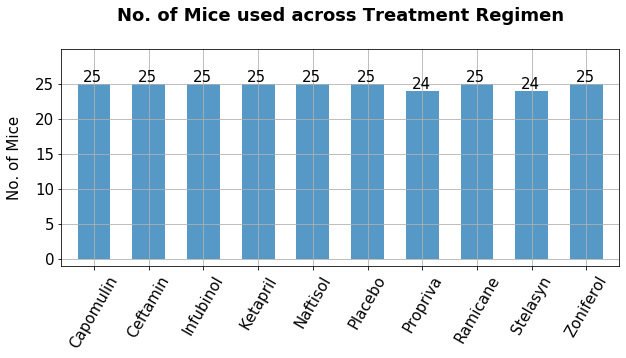

In [47]:
print("Plot created using Matplotlib's pyplot")

fig, axes = plt.subplots(figsize=(10,4))
_=axes.bar(
    x=np.arange(0,len(Regimen_Mice_Count)),  
    height=Regimen_Mice_Count['Number'],
    alpha=0.75,
    width=0.6,
)

#xticks, yticks
_=axes.set_xticks(np.arange(0,len(Regimen_Mice_Count)))
_=axes.set_xticklabels(Regimen_Mice_Count.index.to_list(), fontsize=15, rotation=60)
_=axes.set_yticks(np.arange(0, int(Regimen_Mice_Count.max())+1, 5))
_=axes.set_yticklabels(np.arange(0, int(Regimen_Mice_Count.max())+1, 5), fontsize=15)
#xlabel, #ylabel, #title
_=axes.set_ylabel('No. of Mice', fontsize=15)
_=axes.set_xlim(-0.6,len(Regimen_Mice_Count)-0.4)
_=axes.set_ylim(-1, int(Regimen_Mice_Count.max())+5)
_=axes.set_title("No. of Mice used across Treatment Regimen", fontsize=18,  weight='bold', y=1.1)
_=axes.yaxis.set_label_coords(-0.07,0.5)
#grid
_=axes.grid()
#Annotation
for p in axes.patches:
    _=axes.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height() * 1.01), fontsize=15)

## Pie Plots

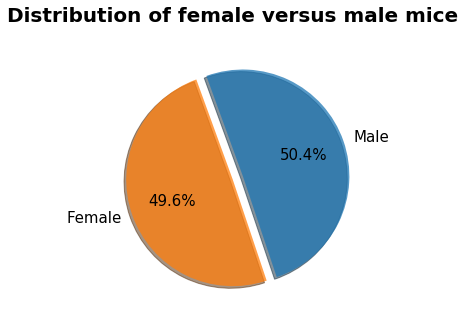

In [841]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

#Group DF with 'Mouse ID' and extract the 'Sex' and take value counts

DF_gender = DF.groupby(['Mouse ID'])['Sex'].first().value_counts()
explode = [(0.1 if gender==DF_gender.idxmax(axis=0) else 0)for gender in DF_gender.index]#Only make the max explode
axes = DF_gender.plot(kind='pie', label='', startangle=110, autopct='%1.1f%%', counterclock=False, explode=explode, shadow=True, colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(DF_gender)], wedgeprops={'alpha':0.75}, fontsize=15)                  
axes.set_aspect("equal")

_=plt.suptitle('Distribution of female versus male mice', fontsize=20, weight='bold', y=1.1)    
_ = plt.tight_layout()
plt.show()


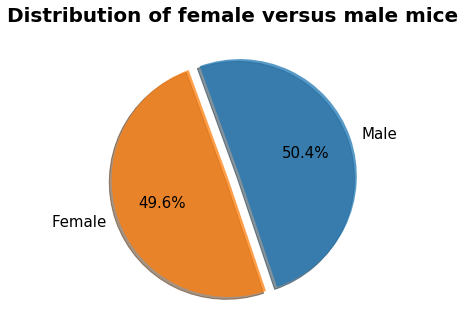

In [842]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

#Group DF with 'Mouse ID' and extract the 'Sex' and take value counts

DF_gender = DF.groupby(['Mouse ID'])['Sex'].first().value_counts()
explode = [(0.1 if gender==DF_gender.idxmax(axis=0) else 0)for gender in DF_gender.index]#Only make the max explode

fig, ax = plt.subplots()
_ = ax.pie(DF_gender, labels=DF_gender.index, startangle=110, autopct='%1.1f%%', counterclock=False, explode=explode, shadow=True, colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(DF_gender)], wedgeprops={'alpha':0.75}, textprops={'fontsize': 15})   
_=ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


_=plt.suptitle('Distribution of female versus male mice', fontsize=20, weight='bold', y=1.1)    
_ = plt.tight_layout()


_= plt.savefig('../Images/graph2.png', bbox_inches = "tight" )
plt.show()



## Quartiles, Outliers and Boxplots

In [843]:
# Calculate the final tumor volume of each mouse across four of the most promising treatment regimens [Capomulin, Ramicane, Infubinol, Ceftamin]. 
# Calculate the IQR and quantitatively determine if there are any potential outliers. 

#Generate indices (Mouse ID, Drug Regimen, Time point) those corresponds to the final tumor volume
Final_Index = DF.groupby(['Mouse ID', 'Drug Regimen'])['Timepoint'].last().reset_index().set_index(['Mouse ID','Drug Regimen', 'Timepoint']).index

#Extract Final Tumour volumne across drug regimes
Final_Tumor_Volume = DF.copy()
Final_Tumor_Volume.set_index(['Mouse ID', 'Drug Regimen', 'Timepoint'], inplace=True)
Final_Tumor_Volume=Final_Tumor_Volume.loc[Final_Index]['Tumor Volume (mm3)']
Final_Tumor_Volume = Final_Tumor_Volume.reset_index()
#Now we have a DF of 248 rows and 4 columns ['Mouse ID', 'Drug Regimen', 'Timepoint', 'Tumor Volume (mm3)']

#####PLEASE READE THIS######
#In the entire dataset, each mouse is observed and studied under only one treatment regime.
#To find the most promising four treatment regimes, we take the average of the final tumour volume in that regime
Regime_Avg_Final_Tumor_Volume = Final_Tumor_Volume.groupby('Drug Regimen')['Tumor Volume (mm3)'].mean()
#Sort this DF in ascending order to find the best performing regimes
Best_Performing_4_Regimes = Regime_Avg_Final_Tumor_Volume.sort_values().index.to_list()[:4]
#I got the best performing regimes as ['Ramicane', 'Capomulin', 'Propriva', 'Ceftamin']
#However, we are hinted that, [Capomulin, Ramicane, Infubinol, Ceftamin]  are most promising. Hence, I am taking  them as they are

Most_Promising_Regimes = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']
#Extract the Final Tumour volumes of only the most promising drug regimes (MPDR)
Final_Tumor_Volume_MPDR = Final_Tumor_Volume[Final_Tumor_Volume['Drug Regimen'].isin(Most_Promising_Regimes)].copy()
Final_Tumor_Volume_MPDR.rename(columns={'Tumor Volume (mm3)': 'Final Tumor Volume (mm3)' }, inplace=True)
print("Final tumor volume of each mouse across four of the most promising treatment regimens [Capomulin, Ramicane, Infubinol, Ceftamin]")
Final_Tumor_Volume_MPDR
#Calculate Q1, Q3 and IQR for each of these treatment regime
Final_Tumor_Volume_MPDR_Quantiles = Final_Tumor_Volume_MPDR.groupby('Drug Regimen').aggregate(Q1 = ('Final Tumor Volume (mm3)', lambda x: pd.DataFrame(x).quantile(.25)), Q3 = ('Final Tumor Volume (mm3)', lambda x: pd.DataFrame(x).quantile(.75)), IQR = ('Final Tumor Volume (mm3)', lambda x: np.quantile(x, 0.75) - np.quantile(x, 0.25)))    
print("IQR of final tumor volumes of mice for the regimes [Capomulin, Ramicane, Infubinol, Ceftamin]")
Final_Tumor_Volume_MPDR_Quantiles
#Check for outliers in each of these regimes; Create a new boolean column 
Final_Tumor_Volume_MPDR['Outlier?'] = Final_Tumor_Volume_MPDR.apply(lambda x: True if ((x['Final Tumor Volume (mm3)'] >  (Final_Tumor_Volume_MPDR_Quantiles.loc[x['Drug Regimen'], 'Q3']+(1.5*Final_Tumor_Volume_MPDR_Quantiles.loc[x['Drug Regimen'], 'IQR']))) | (x['Final Tumor Volume (mm3)'] <  (Final_Tumor_Volume_MPDR_Quantiles.loc[x['Drug Regimen'], 'Q1']-(1.5*Final_Tumor_Volume_MPDR_Quantiles.loc[x['Drug Regimen'], 'IQR'])))) else False, axis=1)

#Filter the outlier
print("Display of any outlier in the regimes [Capomulin, Ramicane, Infubinol, Ceftamin]")
Final_Tumor_Volume_MPDR[Final_Tumor_Volume_MPDR['Outlier?']]
#Mouse c326 shows tremendous improvement compared to other mice trated with Infubinol
print("Mouse c326 shows tremendous improvement compared to other mice trated with Infubinol")


Final tumor volume of each mouse across four of the most promising treatment regimens [Capomulin, Ramicane, Infubinol, Ceftamin]


,Mouse ID,Drug Regimen,Timepoint,Final Tumor Volume (mm3)
0,a203,Infubinol,45,67.973419
1,a251,Infubinol,45,65.525743
3,a275,Ceftamin,45,62.999356
6,a411,Ramicane,45,38.407618
7,a444,Ramicane,45,43.047543
...,...,...,...,...
238,y769,Ceftamin,45,68.594745
239,y793,Capomulin,45,31.896238
240,y865,Ceftamin,45,64.729837
244,z578,Ramicane,45,30.638696


IQR of final tumor volumes of mice for the regimes [Capomulin, Ramicane, Infubinol, Ceftamin]


,Q1,Q3,IQR
Drug Regimen,,,
Capomulin,32.377357,40.159220,7.781863
Ceftamin,48.722078,64.299830,15.577752
Infubinol,54.048608,65.525743,11.477135
Ramicane,31.560470,40.659006,9.098537


Display of any outlier in the regimes [Capomulin, Ramicane, Infubinol, Ceftamin]


,Mouse ID,Drug Regimen,Timepoint,Final Tumor Volume (mm3),Outlier?
31,c326,Infubinol,5,36.321346,True


Mouse c326 shows tremendous improvement compared to other mice trated with Infubinol


,Infubinol,Ceftamin,Ramicane,Capomulin
0,67.973419,62.999356,38.407618,38.982878
1,65.525743,45.000000,43.047543,38.939633
2,57.031862,56.057749,38.810366,30.485985
3,66.083066,55.742829,32.978522,37.074024
4,72.226731,48.722078,38.342008,40.159220


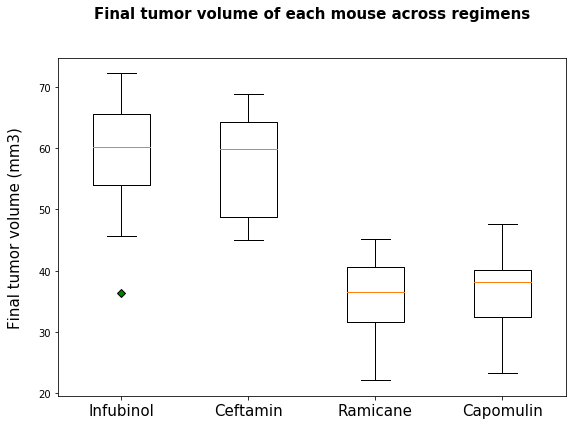

In [844]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

###Reusing some of the code from the previous activity
#Generate indices (Mouse ID, Drug Regimen, Time point) those corresponds to the final tumor volume
Final_Index = DF.groupby(['Mouse ID', 'Drug Regimen'])['Timepoint'].last().reset_index().set_index(['Mouse ID','Drug Regimen', 'Timepoint']).index

#Extract Final Tumour volumne across drug regimes
Final_Tumor_Volume = DF.copy()
Final_Tumor_Volume.set_index(['Mouse ID', 'Drug Regimen', 'Timepoint'], inplace=True)
Final_Tumor_Volume=Final_Tumor_Volume.loc[Final_Index]['Tumor Volume (mm3)']
Final_Tumor_Volume = Final_Tumor_Volume.reset_index()
#Now we have a DF of 248 rows and 4 columns ['Mouse ID', 'Drug Regimen', 'Timepoint', 'Tumor Volume (mm3)']


Most_Promising_Regimes = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']
#Extract the Final Tumour volumes of only the most promising drug regimes (MPDR)
Final_Tumor_Volume_MPDR = Final_Tumor_Volume[Final_Tumor_Volume['Drug Regimen'].isin(Most_Promising_Regimes)].copy()
Final_Tumor_Volume_MPDR.rename(columns={'Tumor Volume (mm3)': 'Final Tumor Volume (mm3)' }, inplace=True)


#Preparation for Box plot
#Now, we need only 'Drug Regimen' and 'Final Tumor Volume (mm3)'
Final_Tumor_Volume_MPDR_sel = Final_Tumor_Volume_MPDR[['Drug Regimen', 'Final Tumor Volume (mm3)']]

#Now, create a dictionary with keys = regime names and value as list of Final Tumor Volume (mm3). Easy peasy with dictionary comprehension !!
Dict_Regime_Final_Tumor_Volume = {regime:Final_Tumor_Volume_MPDR_sel[Final_Tumor_Volume_MPDR_sel['Drug Regimen']==regime]['Final Tumor Volume (mm3)'].to_list() for regime in Final_Tumor_Volume_MPDR_sel['Drug Regimen'].unique()} 
#Diplay this dictionary as DataFrame
pd.DataFrame(Dict_Regime_Final_Tumor_Volume).head(5)

#Time for Box plot
fig, ax = plt.subplots(figsize=(8,6))
green_diamond = dict(markerfacecolor='g', marker='D') #Outlier styling
whiskers, caps, boxes, medians, fliers, _ = ax.boxplot(Dict_Regime_Final_Tumor_Volume.values(), flierprops=green_diamond)
text = ax.set_xticklabels(Dict_Regime_Final_Tumor_Volume.keys(), fontsize=15)
_=ax.set_title("Final tumor volume of each mouse across regimens", fontsize=15, weight='bold', y=1.1)
_=ax.set_ylabel("Final tumor volume (mm3)", fontsize=15)
_=ax.yaxis.set_label_coords(-0.07,0.5)
_ = plt.tight_layout()
_= plt.savefig('../Images/graph3.png', bbox_inches = "tight" )
plt.show()


## Line and Scatter Plots

In [48]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
243,l897,0,45.000000,0,Capomulin,Male,17,19
256,l897,5,45.462243,0,Capomulin,Male,17,19
618,l897,10,46.154737,0,Capomulin,Male,17,19
864,l897,15,44.061521,0,Capomulin,Male,17,19
998,l897,20,44.813093,0,Capomulin,Male,17,19
1164,l897,25,45.354679,0,Capomulin,Male,17,19
1390,l897,30,39.352792,1,Capomulin,Male,17,19
1468,l897,35,37.682767,1,Capomulin,Male,17,19
1749,l897,40,38.343902,1,Capomulin,Male,17,19
1817,l897,45,38.846876,1,Capomulin,Male,17,19


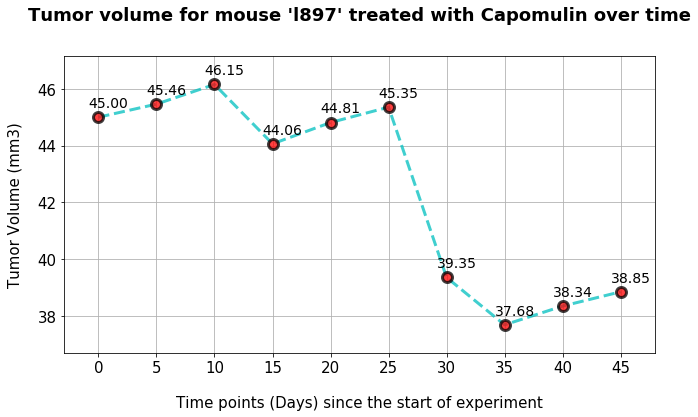

In [189]:
DF_Capolulin = DF[DF['Drug Regimen']=='Capomulin'].copy()

#set a seed, to produce the same output always
random.seed(10) #Change this seed to get a different mouse data
#Randomly sample one mouse
mouse_in_capolulin = random.sample(list(DF_Capolulin['Mouse ID'].unique()), 1)
#Take the Data of only this mouse
DF_mouse_in_capolulin = DF_Capolulin[DF_Capolulin['Mouse ID']==mouse_in_capolulin[0]]
#It looks like, the data is already sorted on Timepoints, but just in case, sort once again !!
DF_mouse_in_capolulin = DF_mouse_in_capolulin.sort_values(by='Timepoint')
DF_mouse_in_capolulin

fig, axes = plt.subplots(figsize=(10,6))
_=axes.plot(
    DF_mouse_in_capolulin['Timepoint'],  
    DF_mouse_in_capolulin['Tumor Volume (mm3)'],
    'co--',
    linewidth='3',
    markeredgewidth=3, markeredgecolor='k', markerfacecolor='r',markersize=10,
    alpha=0.75,
)

#xticks, yticks
_=axes.set_xticks(DF_mouse_in_capolulin['Timepoint'].to_list())
_=axes.set_xticklabels(DF_mouse_in_capolulin['Timepoint'].to_list(), fontsize=15)
_=axes.set_yticks([int(tick) for tick in axes.get_yticks()])
_=axes.set_yticklabels([int(tick) for tick in axes.get_yticks()], fontsize=15)

#xlabel, #ylabel, #title
_=axes.set_ylabel('Tumor Volume (mm3)', fontsize=15)
_=axes.set_xlabel('Time points (Days) since the start of experiment', fontsize=15)
_=axes.set_xlim(DF_mouse_in_capolulin['Timepoint'].min()-3,DF_mouse_in_capolulin['Timepoint'].max()+3)
_=axes.set_ylim(DF_mouse_in_capolulin['Tumor Volume (mm3)'].min()-1, DF_mouse_in_capolulin['Tumor Volume (mm3)'].max()+1)
_=axes.set_title(f"Tumor volume for mouse '{mouse_in_capolulin[0]}' treated with Capomulin over time", fontsize=18,  weight='bold', y=1.1)
_=axes.yaxis.set_label_coords(-0.07,0.5)
_=axes.xaxis.set_label_coords(0.5,-0.14)
#grid
_=axes.grid()

#Annotate
# zip joins x and y coordinates in pairs
for x,y in zip(DF_mouse_in_capolulin['Timepoint'].to_list(),DF_mouse_in_capolulin['Tumor Volume (mm3)'].to_list()):

    label = "{:.2f}".format(y)

    _=axes.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text ('offset pixels'  is the other option)
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 fontsize=14,
                 color='k') 

#Save
_ = plt.tight_layout()

_= plt.savefig('../Images/graph4.png', bbox_inches = "tight" )
plt.show()